In [1]:
import requests
import pandas as pd
from urllib.request import Request, urlopen
from sodapy import Socrata
import json
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import ipywidgets as wd
from ipywidgets import interact
import seaborn as sns
#import ptitprince as pt
import base64

In [2]:
with open("newSecret.json", "r") as f:
    config = json.load(f)

token = config["TOKEN_API_OD"]
user=config["user"]
passwd=config["pw"]
client_id=config["clientId"]
client_secret=config["clientSecret"]

In [3]:
def get_access_token(client_id, client_secret):
    # URL para obtener el token de acceso
    auth_url = 'https://accounts.spotify.com/api/token'
    
    # Creación del encabezado de autorización con client_id y client_secret codificados en base64
    auth_header = {
        'Authorization': f'Basic {base64.b64encode((client_id + ":" + client_secret).encode()).decode()}'
    }
    
    # Datos necesarios para la petición POST
    auth_data = {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret
    }
    
    # Realizar la petición POST
    auth_response = requests.post(auth_url, data=auth_data, headers=auth_header)
    
    # Extraer la respuesta y obtener el token de acceso
    auth_response_data = auth_response.json()
    access_token = auth_response_data['access_token']
    
    # Devolver el token de acceso
    return access_token


In [4]:
def get_genres(access_token, limit=50, offset=0):
    genres_url = 'https://api.spotify.com/v1/browse/categories'
    
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    
    params = {
        'limit': limit,
        'offset': offset
    }
    
    # Realiza la petición GET a la API de Spotify para obtener los géneros
    response = requests.get(genres_url, headers=headers, params=params)
    
    # Extrae la respuesta y convierte el JSON en un diccionario de Python
    genres_data = response.json()
    
    # Crea una lista de tuplas, donde cada tupla contiene el ID del género y su nombre
    genres = [(category['id'], category['name']) for category in genres_data['categories']['items']]
    
    return genres

In [5]:
access_token = get_access_token(client_id, client_secret)  # Suponiendo que ya has definido client_id y client_secret
genres_list = get_genres(access_token)

# Crear un DataFrame a partir de la lista de géneros
df_genres = pd.DataFrame(genres_list, columns=['Genre_ID', 'Genre_Name'])

In [6]:
df_genres

,Genre_ID,Genre_Name
0,toplists,Top Lists
1,0JQ5DAqbMKFGcCCKMatU5w,Made in Colombia
2,0JQ5DAqbMKFPw634sFwguI,EQUAL
3,0JQ5DAqbMKFOOxftoKZxod,RADAR
4,0JQ5DAqbMKFF9bY76LXmfI,Frequency
5,0JQ5DAqbMKFx0uLQR2okcc,At Home
6,0JQ5DAqbMKFLb2EqgLtpjC,Wellness
7,0JQ5DAqbMKFCbimwdOYlsl,Focus
8,0JQ5DAqbMKFxXaXKP7zcDp,Latin
9,0JQ5DAqbMKFEC4WFtoNRpw,Pop


In [7]:
def extract_artists_to_dataframe(response_data):
    # Lista para almacenar datos de artistas
    artist_list = []

    # Iterar sobre cada artista en la respuesta
    for artist in response_data['artists']:
        # Extraer la información relevante
        artist_info = {
            'Name': artist['name'],
            'Genres': ', '.join(artist['genres']),
            'Popularity': artist['popularity'],
            'Spotify_URL': artist['external_urls']['spotify'],
            'Followers': artist['followers']['total'],
            'Image_URL': artist['images'][0]['url'] if artist['images'] else None, # Toma la primera imagen, si existe
            'Artist_ID': artist['id'],
            'Artist_Type': artist['type'],
            'Artist_URI': artist['uri']
        }
        # Agregar a la lista
        artist_list.append(artist_info)

    # Convertir lista en DataFrame
    df_artists = pd.DataFrame(artist_list)

    return df_artists


In [8]:
def get_artists_from_spotify(token, artist_ids):
    """
    Fetch artist details from Spotify's API.
    
    :param access_token: Token for API authorization.
    :param artist_ids: List of artist IDs.
    :return: Response data as a dictionary.
    """
    
    # Endpoint de la API
    base_url = "https://api.spotify.com/v1/artists"
    
    # Headers de la petición (incluye el token de acceso para autorización)
    headers = {
        "Authorization": f"Bearer {token}"
    }
    
    # Parámetros de la petición (IDs de los artistas)
    params = {
        "ids": ",".join(artist_ids)
    }
    
    # Realizar la petición GET a la API de Spotify
    response = requests.get(base_url, headers=headers, params=params)
    
    # Convertir la respuesta en formato JSON a un diccionario de Python
    response_data = response.json()

    return response_data

# Ejemplo de uso:

artist_ids = ["2CIMQHirSU0MQqyYHq0eOx", "57dN52uHvrHOxijzpIgu3E"]  # Reemplaza con los IDs de los artistas que quieras consultar
token=access_token
# Obtener respuesta de la API
response_data = get_artists_from_spotify(token, artist_ids)

# Procesar la respuesta con la función extract_artists_to_dataframe
df_artist = extract_artists_to_dataframe(response_data)
#print(df)
df_artist

,Name,Genres,Popularity,Spotify_URL,Followers,Image_URL,Artist_ID,Artist_Type,Artist_URI
0,deadmau5,"canadian electronic, complextro, edm, electro ...",66,https://open.spotify.com/artist/2CIMQHirSU0MQq...,2787041,https://i.scdn.co/image/ab6761610000e5ebc5ceb0...,2CIMQHirSU0MQqyYHq0eOx,artist,spotify:artist:2CIMQHirSU0MQqyYHq0eOx
1,Ratatat,indietronica,63,https://open.spotify.com/artist/57dN52uHvrHOxi...,590531,https://i.scdn.co/image/2f0c6c465a83cd196e651e...,57dN52uHvrHOxijzpIgu3E,artist,spotify:artist:57dN52uHvrHOxijzpIgu3E


In [9]:
import requests

def get_artists_by_genre(query, access_token, limit=50):
    search_url = 'https://api.spotify.com/v1/search'
    
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    
    params = {
        'q': f"genre:\"{query}\"",
        'type': 'artist',
        'limit': limit
    }
    
    response = requests.get(search_url, headers=headers, params=params)
    response_data = response.json()
    
    if 'artists' in response_data:
        return [artist['id'] for artist in response_data['artists']['items']]
    else:
        print("Error en la respuesta de la API:", response_data)
        return []





In [10]:
genre = "death metal"
metal_artist_ids = get_artists_by_genre(genre, access_token)
print(metal_artist_ids)

['1IQ2e1buppatiN1bxUVkrk', '5pqvAI85RMxL9K0xHvSwGu', '0GDGKpJFhVpcjIGF8N6Ewt', '57ylwQTnFnIhJh4nu4rxCs', '6vXYoy8ouRVib302zxaxFF', '24Oiw7BlvO1BETecDLJt6m', '1C62FV9Cltn9L4c9jAwCyk', '3pulcT2wt7FEG10lQlqDJL', '6JW8wliOEwaDZ231ZY7cf4', '3iCJOi5YKh247eutgCyLFe', '0FZcPgWI3BsFQl4rOAGSHT', '2tjnvrUmP46XNjFh9V0NGc', '4Uv5bceTJ2h3tLlssUNDNP', '0yLwGBQiBqhXOvmTfH2A7n', '4f5V3PQ66nIrBCqugJtaGn', '4d6Rawrese4OLF1zZCztod', '5274obTQJjzjyycRyJlfml', '2OTuoIi28WybVbVcykc237', '6HZr7Fs2VfV1PYHIwo8Ylc', '4UgQ3EFa8fEeaIEg54uV5b', '0ybFZ2Ab08V8hueghSXm6E', '3et9upNERQI5IYt5jEDTxM', '1xUhNgw4eJDZfvumIpcz1B', '2i7CQcVBh2K6uOR3CH09M1', '0DCw6lHkzh9t7f8Hb4Z0Sx', '1DgmdsnwOexqTH8ohPCFAU', '4tDkeVxH0CSkNiLVrsYmQs', '0uNj4RxFjG0iVPlZS753en', '7k29FbDq69ju2fe6zTskxY', '1bPBx2qbpWzEoLujeHC3G7', '1AdrYGYDz4oa9dvW2jfFrG', '0qJpY7K8p7g6sacvaGNt6i', '2Ah9OuOj7B57gPD1cbwiaE', '4xTDPgk4jHCF0qui3dH6BS', '76xrrejizyQpKukBIhnf3D', '7wqP36o9lqWteOCxBnXlwx', '4HgqjpBaWctBWVHafQIpRt', '67ZMMtA88DDO0gTuRrzGjn', '6EFV3PmaXb

In [11]:
#artist_ids = ["2CIMQHirSU0MQqyYHq0eOx", "57dN52uHvrHOxijzpIgu3E"]  # Reemplaza con los IDs de los artistas que quieras consultar
token=access_token
# Obtener respuesta de la API
response_data = get_artists_from_spotify(token, metal_artist_ids)

# Procesar la respuesta con la función extract_artists_to_dataframe
df_metal_artist = extract_artists_to_dataframe(response_data)
#print(df)
df_metal_artist

,Name,Genres,Popularity,Spotify_URL,Followers,Image_URL,Artist_ID,Artist_Type,Artist_URI
0,Slayer,"alternative metal, death metal, groove metal, ...",65,https://open.spotify.com/artist/1IQ2e1buppatiN...,3753386,https://i.scdn.co/image/8c81130db7b5f933412c49...,1IQ2e1buppatiN1bxUVkrk,artist,spotify:artist:1IQ2e1buppatiN1bxUVkrk
1,Currents,"melodic metalcore, metalcore, progressive deat...",59,https://open.spotify.com/artist/5pqvAI85RMxL9K...,198697,https://i.scdn.co/image/ab6761610000e5ebe802e9...,5pqvAI85RMxL9K0xHvSwGu,artist,spotify:artist:5pqvAI85RMxL9K0xHvSwGu
2,Gojira,"alternative metal, french death metal, french ...",61,https://open.spotify.com/artist/0GDGKpJFhVpcjI...,1262352,https://i.scdn.co/image/ab6761610000e5eb96c494...,0GDGKpJFhVpcjIGF8N6Ewt,artist,spotify:artist:0GDGKpJFhVpcjIGF8N6Ewt
3,In Flames,"alternative metal, gothenburg metal, melodic d...",62,https://open.spotify.com/artist/57ylwQTnFnIhJh...,1137674,https://i.scdn.co/image/ab6761610000e5eb5c3bd9...,57ylwQTnFnIhJh4nu4rxCs,artist,spotify:artist:57ylwQTnFnIhJh4nu4rxCs
4,Lorna Shore,"blackened deathcore, melodic metalcore, sympho...",58,https://open.spotify.com/artist/6vXYoy8ouRVib3...,564337,https://i.scdn.co/image/ab6761610000e5eb49e1d0...,6vXYoy8ouRVib302zxaxFF,artist,spotify:artist:6vXYoy8ouRVib302zxaxFF
5,Slaughter to Prevail,"russian metal, russian metalcore, slamming dea...",57,https://open.spotify.com/artist/24Oiw7BlvO1BET...,575890,https://i.scdn.co/image/ab6761610000e5eb65de98...,24Oiw7BlvO1BETecDLJt6m,artist,spotify:artist:24Oiw7BlvO1BETecDLJt6m
6,Emmure,"deathcore, melodic metalcore, metalcore, nu-me...",54,https://open.spotify.com/artist/1C62FV9Cltn9L4...,331643,https://i.scdn.co/image/ab6761610000e5ebf96bda...,1C62FV9Cltn9L4c9jAwCyk,artist,spotify:artist:1C62FV9Cltn9L4c9jAwCyk
7,Amon Amarth,"groove metal, melodic death metal, metal, powe...",59,https://open.spotify.com/artist/3pulcT2wt7FEG1...,1082359,https://i.scdn.co/image/ab6761610000e5eb131d4f...,3pulcT2wt7FEG10lQlqDJL,artist,spotify:artist:3pulcT2wt7FEG10lQlqDJL
8,Sepultura,"alternative metal, brazilian groove metal, bra...",59,https://open.spotify.com/artist/6JW8wliOEwaDZ2...,1820437,https://i.scdn.co/image/ab6761610000e5eb716f57...,6JW8wliOEwaDZ231ZY7cf4,artist,spotify:artist:6JW8wliOEwaDZ231ZY7cf4
9,I See Stars,"deathstep, melodic metalcore, metalcore, neon ...",52,https://open.spotify.com/artist/3iCJOi5YKh247e...,453406,https://i.scdn.co/image/ab6761610000e5eba1a68c...,3iCJOi5YKh247eutgCyLFe,artist,spotify:artist:3iCJOi5YKh247eutgCyLFe


In [12]:
def get_artists_by_genre(query, access_token, total_limit=3000):
    search_url = 'https://api.spotify.com/v1/search'
    headers = {'Authorization': f'Bearer {access_token}'}

    MetaL_artist_ids = []
    limit = 50  # Máximo permitido por Spotify
    offset = 0  # Iniciar en el primer resultado

    while len(artist_ids) < total_limit:
        params = {
            'q': f"genre:\"{query}\"",
            'type': 'artist',
            'limit': limit,
            'offset': offset
        }

        response = requests.get(search_url, headers=headers, params=params)
        
        # Verificar la respuesta antes de intentar decodificar JSON
        if response.status_code != 200:
            print(f"Error en la solicitud: {response.status_code}")
            break

        response_data = response.json()
        
        # Verificar si hay artistas en la respuesta
        if 'artists' in response_data and 'items' in response_data['artists']:
            batch_ids = [artist['id'] for artist in response_data['artists']['items']]
            MetaL_artist_ids.extend(batch_ids)
            
            # Si se recuperaron menos artistas de los esperados, podría ser la última página
            if len(batch_ids) < limit:
                print("Alcanzado el final de los resultados.")
                break
        else:
            print("No se encontraron más artistas o hay un error en la respuesta.")
            break

        # Incrementar el offset para la siguiente tanda de resultados
        offset += limit

        # Opcional: Agregar un pequeño retraso entre las solicitudes para evitar ser bloqueado por la API por exceso de solicitudes
       # time.sleep(1)

    return MetaL_artist_ids[:total_limit]  # Devolver hasta el límite total deseado



In [13]:
genre = "Djent"
MetaL_artist_ids = get_artists_by_genre(genre, access_token, total_limit=3000)
print(len(MetaL_artist_ids))  # Esto debería imprimir el número de artist IDs recopilados, hasta un máximo de 9000.

Alcanzado el final de los resultados.
251


In [14]:
def extract_artists_to_dataframe2(artist_list):
    # Lista para almacenar los datos formateados de los artistas
    formatted_artist_data = []

    # Iterar sobre cada artista en la lista proporcionada
    for artist in artist_list:
        # Extraer la información relevante
        artist_info = {
            'Name': artist['name'],
            'Genres': ', '.join(artist['genres']),
            'Popularity': artist['popularity'],
            'Followers': artist['followers']['total'],
            'Artist_URI': artist['uri']
        }
        # Agregar a la lista
        formatted_artist_data.append(artist_info)

    # Convertir la lista de diccionarios en un DataFrame
    df_artist = pd.DataFrame(formatted_artist_data)
    return df_artist


In [15]:
from time import sleep

def get_artists_from_spotify2(token, artist_ids, batch_size=50):
    """
    Fetch artist details from Spotify's API in batches.
    
    :param access_token: Token for API authorization.
    :param artist_ids: List of artist IDs.
    :param batch_size: Size of the artist ID batches to request.
    :return: List of artist data dictionaries.
    """
    # Endpoint de la API
    base_url = "https://api.spotify.com/v1/artists"
    
    # Lista para almacenar todos los datos de los artistas
    all_artist_data = []
    
    # Dividir la lista de IDs en batches
    for i in range(0, len(artist_ids), batch_size):
        batch = artist_ids[i:i+batch_size]
        
        # Headers de la petición (incluye el token de acceso para autorización)
        headers = {
            "Authorization": f"Bearer {token}"
        }
        
        # Parámetros de la petición (IDs de los artistas)
        params = {
            "ids": ",".join(batch)
        }
        
        # Realizar la petición GET a la API de Spotify
        response = requests.get(base_url, headers=headers, params=params)
        
        # Verificar el estado de la respuesta
        if response.status_code == 200:
            # Convertir la respuesta en formato JSON a un diccionario de Python
            batch_data = response.json()
            all_artist_data.extend(batch_data['artists'])
        else:
            print(f"Error en el batch {i//batch_size}: {response.status_code}")
            sleep(1)  # Esperar un segundo antes de continuar para no sobrecargar la API
        
    return all_artist_data



In [16]:
batch_size = 50  # Spotify API limit
df_METAL_artists = pd.DataFrame()  # DataFrame vacío para almacenar los datos

# Procesar los artist IDs en batches
for i in range(0, len(MetaL_artist_ids), batch_size):
    batch_ids = MetaL_artist_ids[i:i+batch_size]
    batch_data = get_artists_from_spotify2(token, batch_ids, batch_size)
    df_batch = extract_artists_to_dataframe2(batch_data)  # Asumiendo que esta función ya está definida
    df_METAL_artists = pd.concat([df_METAL_artists, df_batch], ignore_index=True)

#print(df_artists)


In [17]:
df_METAL_artists

,Name,Genres,Popularity,Followers,Artist_URI
0,Mick Gordon,"electronic djent, video game music",58,405732,spotify:artist:13ab1LgQZ3tQOhkDRRYB8Y
1,Meshuggah,"alternative metal, djent, groove metal, metal,...",53,666417,spotify:artist:3ggwAqZD3lyT2sbovlmfQY
2,Periphery,"djent, melodic metalcore, progressive metal, p...",52,479868,spotify:artist:6d24kC5fxHFOSEAmjQPPhc
3,Invent Animate,"american metalcore, djent, melodic metalcore, ...",50,121802,spotify:artist:3ALVPmg5sZexSVD2m9atEt
4,ERRA,"alabama metal, djent, melodic metalcore, metal...",49,247727,spotify:artist:2UoOdQyBGyzrEfxcY77ce0
...,...,...,...,...,...
246,Gentuza,electronic djent,0,110,spotify:artist:4IEmznAhgeekv4z92ey0ka
247,Cyclamen,djent,0,2755,spotify:artist:6xsVBY76awVOIfVqWA5yyy
248,Bastila,electronic djent,0,196,spotify:artist:040ODkoHCI2E6ktlOoKmu0
249,No Consequence,"djent, uk metalcore",3,2816,spotify:artist:4OB9RSU4XPYtA9JGAzlpKo


In [18]:
df_METAL_artists.loc[df_METAL_artists['Name']=='Masacre']

,Name,Genres,Popularity,Followers,Artist_URI


In [19]:
df_METAL_artists.loc[df_METAL_artists['Name']=='Suffocation']

,Name,Genres,Popularity,Followers,Artist_URI


In [20]:
#df_METAL_artists.to_csv('Spotify_extracted.csv',index=False)

In [21]:
df_METAL_artists.loc[df_METAL_artists['Name']=='Blood May Rise']

,Name,Genres,Popularity,Followers,Artist_URI


In [22]:
def get_markets(access_token, limit=50, offset=0):
    markets_url = 'https://api.spotify.com/v1/browse/categories'
    
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    
    params = {
        'limit': limit,
        'offset': offset
    }
    
    # Realiza la petición GET a la API de Spotify para obtener los géneros
    response = requests.get(markets_url, headers=headers, params=params)
    
    # Extrae la respuesta y convierte el JSON en un diccionario de Python
    markets_data = response.json()
    
    # Crea una lista de tuplas, donde cada tupla contiene el ID del género y su nombre
    markets = [(category['id'], category['name']) for category in markets_data['categories']['items']]
    
    return markets

In [23]:
access_token = get_access_token(client_id, client_secret)  # Suponiendo que ya has definido client_id y client_secret
markets_list = get_markets(access_token)

# Crear un DataFrame a partir de la lista de géneros
df_markets = pd.DataFrame(markets_list, columns=['Market_ID', 'Market_Name'])

In [24]:
df_markets

,Market_ID,Market_Name
0,toplists,Top Lists
1,0JQ5DAqbMKFGcCCKMatU5w,Made in Colombia
2,0JQ5DAqbMKFPw634sFwguI,EQUAL
3,0JQ5DAqbMKFOOxftoKZxod,RADAR
4,0JQ5DAqbMKFF9bY76LXmfI,Frequency
5,0JQ5DAqbMKFx0uLQR2okcc,At Home
6,0JQ5DAqbMKFLb2EqgLtpjC,Wellness
7,0JQ5DAqbMKFCbimwdOYlsl,Focus
8,0JQ5DAqbMKFxXaXKP7zcDp,Latin
9,0JQ5DAqbMKFEC4WFtoNRpw,Pop


In [25]:
def get_artists_by_name(query, access_token, limit=50):
    search_url = 'https://api.spotify.com/v1/search'
    
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    
    params = {
        'q': f"name:\"{query}\"",
        'type': 'artist',
        'limit': limit
    }
    
    response = requests.get(search_url, headers=headers, params=params)
    response_data = response.json()
    
    if 'artists' in response_data:
        return [artist['id'] for artist in response_data['artists']['items']]
    else:
        print("Error en la respuesta de la API:", response_data)
        return []

In [64]:
name = "SYRACUSÆ"
names = get_artists_by_name(name, access_token)
print(names)

['65uP1jjzWh4VISZCA4s3X7', '3tPNUZKUf9Pa8R84yWpSvO', '64iLtTMfnTAuuMbRk66boJ', '3s5NSrjy5sXASsWsm55iPy', '2tJE40GixcEoh9zwoBD07H', '4LOPGgD3DBWffxYypHDzry', '4lqBkVmOyYfnDQCm5mA5ko', '6xinS4Wgb422R7KrrJ9UYU', '5AB3ONEZzBBSvjYYStYgap', '6dX29Av0TojL5ZMOOgLliI', '5JDM5S7eyY3ypNOyS5e0ML', '6WjPUWcR55uboKEjvH1Pt7', '0axxjRxJBx2ciiPYRcBPJ2', '4JmS6FBtKxZ9sQwS4Ezk4j', '59mntshH5MOPANbk9f69hP', '4ZiIj8ThbKaep4Kc0V5xbZ', '3ntNlXR1aenb9hNEL02WYH', '245qp5aDyBGuhSFu8GGSJi', '0I4flbOXVYUts2wY3cPt1R', '4TSO4eUt8kze7Ac5Gg1y8e', '2LXgEluAGEdhhBqTYtve0g', '2rD1kXQRKt6KpmKnLAZZ2E', '08cAZWaoVZnCrDCDY6P7tk', '0KIxr4HfjzUEBKy6vlfR9O', '7sUmD0wgjQR7cavOCCdP5W', '2JTmMIiuyMwoO9nvPoZJ2Z', '4XZ4x9dUVCLnrm8oRQMlDt', '1qo7mKjITlrCOs9nptnPEb', '0hKhw4tF73tq6390kUouxM']


In [65]:
token=access_token
# Obtener respuesta de la API
response_data_names = get_artists_from_spotify(token, names)

# Procesar la respuesta con la función extract_artists_to_dataframe
df_metal_artist_names = extract_artists_to_dataframe(response_data_names)
#print(df)
df_metal_artist_names

,Name,Genres,Popularity,Spotify_URL,Followers,Image_URL,Artist_ID,Artist_Type,Artist_URI
0,Paid Master Received Contract Signed Editor St...,,0,https://open.spotify.com/artist/65uP1jjzWh4VIS...,46,None,65uP1jjzWh4VISZCA4s3X7,artist,spotify:artist:65uP1jjzWh4VISZCA4s3X7
1,Syracuse Crunch,,5,https://open.spotify.com/artist/3tPNUZKUf9Pa8R...,35,https://i.scdn.co/image/ab6761610000e5ebe18fb5...,3tPNUZKUf9Pa8R84yWpSvO,artist,spotify:artist:3tPNUZKUf9Pa8R84yWpSvO
2,1000names,,3,https://open.spotify.com/artist/64iLtTMfnTAuuM...,1967,https://i.scdn.co/image/ab67616d0000b2738e3ba9...,64iLtTMfnTAuuMbRk66boJ,artist,spotify:artist:64iLtTMfnTAuuMbRk66boJ
3,SYRACUSÆ,,7,https://open.spotify.com/artist/3s5NSrjy5sXASs...,1673,https://i.scdn.co/image/ab6761610000e5eb750d3e...,3s5NSrjy5sXASsWsm55iPy,artist,spotify:artist:3s5NSrjy5sXASsWsm55iPy
4,10NamesJune,,0,https://open.spotify.com/artist/2tJE40GixcEoh9...,28,https://i.scdn.co/image/ab6761610000e5eb8a2fac...,2tJE40GixcEoh9zwoBD07H,artist,spotify:artist:2tJE40GixcEoh9zwoBD07H
5,Syracuse University Singers,,7,https://open.spotify.com/artist/4LOPGgD3DBWffx...,38,https://i.scdn.co/image/ab67616d0000b273eab73a...,4LOPGgD3DBWffxYypHDzry,artist,spotify:artist:4LOPGgD3DBWffxYypHDzry
6,NAME101,,0,https://open.spotify.com/artist/4lqBkVmOyYfnDQ...,0,None,4lqBkVmOyYfnDQCm5mA5ko,artist,spotify:artist:4lqBkVmOyYfnDQCm5mA5ko
7,Syracuse University,college marching band,2,https://open.spotify.com/artist/6xinS4Wgb422R7...,55,None,6xinS4Wgb422R7KrrJ9UYU,artist,spotify:artist:6xinS4Wgb422R7KrrJ9UYU
8,119 No Names,,0,https://open.spotify.com/artist/5AB3ONEZzBBSvj...,43,https://i.scdn.co/image/ab6761610000e5eb3a6568...,5AB3ONEZzBBSvjYYStYgap,artist,spotify:artist:5AB3ONEZzBBSvjYYStYgap
9,Syracuse Symphony Orchestra,,6,https://open.spotify.com/artist/6dX29Av0TojL5Z...,5,https://i.scdn.co/image/ab67616d0000b273555c7e...,6dX29Av0TojL5ZMOOgLliI,artist,spotify:artist:6dX29Av0TojL5ZMOOgLliI


In [66]:
df_metal_artist_names.loc[df_metal_artist_names['Name']=='SYRACUSÆ','Artist_ID']

3    3s5NSrjy5sXASsWsm55iPy
Name: Artist_ID, dtype: object

In [29]:
def get_tracks_from_id(token, artist_ids, batch_size=50):
    """
    Fetch artist details from Spotify's API in batches.
    
    :param access_token: Token for API authorization.
    :param artist_ids: List of artist IDs.
    :param batch_size: Size of the artist ID batches to request.
    :return: List of artist data dictionaries.
    """
    # Endpoint de la API
    base_url = "https://api.spotify.com/v1/tracks"
    
    # Lista para almacenar todos los datos de los artistas
    all_artist_tracks = []
    
    # Dividir la lista de IDs en batches
    for i in range(0, len(artist_ids), batch_size):
        batch = artist_ids[i:i+batch_size]
        
        # Headers de la petición (incluye el token de acceso para autorización)
        headers = {
            "Authorization": f"Bearer {token}"
        }
        
        # Parámetros de la petición (IDs de los artistas)
        params = {
            "ids": ",".join(batch)
        }
        
        # Realizar la petición GET a la API de Spotify
        response = requests.get(base_url, headers=headers, params=params)
        
        # Verificar el estado de la respuesta
        if response.status_code == 200:
            # Convertir la respuesta en formato JSON a un diccionario de Python
            batch_data = response.json()
            all_artist_tracks.extend(batch_data['tracks'])
        else:
            print(f"Error en el batch {i//batch_size}: {response.status_code}")
            sleep(1)  # Esperar un segundo antes de continuar para no sobrecargar la API
        
    return all_artist_tracks

In [30]:
bands_list=['SYRACUSÆ']

In [31]:
def get_albums_from_artist_id(token, artist_id):
    """
    Fetch albums from an artist from Spotify's API.
    
    :param token: Token for API authorization.
    :param artist_id: Artist ID.
    :return: List of album IDs.
    """
    albums_url = f"https://api.spotify.com/v1/artists/{artist_id}/albums"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(albums_url, headers=headers)
    
    if response.status_code == 200:
        albums_data = response.json()
        return [album['id'] for album in albums_data['items']]
    else:
        print(f"Error fetching albums: {response.status_code}")
        return []

def get_tracks_from_album_ids(token, album_ids):
    """
    Fetch tracks from album IDs from Spotify's API.
    
    :param token: Token for API authorization.
    :param album_ids: List of album IDs.
    :return: List of track data dictionaries.
    """
    all_tracks = []
    for album_id in album_ids:
        tracks_url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
        headers = {"Authorization": f"Bearer {token}"}
        response = requests.get(tracks_url, headers=headers)
        
        if response.status_code == 200:
            tracks_data = response.json()
            all_tracks.extend(tracks_data['items'])
        else:
            print(f"Error fetching tracks for album {album_id}: {response.status_code}")
    
    return all_tracks




In [32]:
artist_id = '4hXQr6dceuzWxBlbLLMCmI'
album_ids = get_albums_from_artist_id(token, artist_id)
tracks = get_tracks_from_album_ids(token, album_ids)

In [33]:
tracks_df=pd.DataFrame(tracks)

In [34]:
tracks_df

,artists,available_markets,disc_number,duration_ms,explicit,external_urls,href,id,is_local,name,preview_url,track_number,type,uri
0,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,62769,False,{'spotify': 'https://open.spotify.com/track/4B...,https://api.spotify.com/v1/tracks/4B7EifbgltSq...,4B7EifbgltSqFAHeHecUUD,False,RENGOKU 煉獄,https://p.scdn.co/mp3-preview/68219a0b092c2e0d...,1,track,spotify:track:4B7EifbgltSqFAHeHecUUD
1,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,237028,False,{'spotify': 'https://open.spotify.com/track/3b...,https://api.spotify.com/v1/tracks/3bh4GkOcNDYA...,3bh4GkOcNDYAuEdGCHzBqW,False,Neon Genesis,https://p.scdn.co/mp3-preview/f554dae13085d9b3...,1,track,spotify:track:3bh4GkOcNDYAuEdGCHzBqW
2,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,276461,False,{'spotify': 'https://open.spotify.com/track/3u...,https://api.spotify.com/v1/tracks/3ux9SHfmAPUx...,3ux9SHfmAPUxcSbFDTnCLQ,False,King Of Curses,https://p.scdn.co/mp3-preview/931c307090f0bef6...,1,track,spotify:track:3ux9SHfmAPUxcSbFDTnCLQ
3,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,60923,True,{'spotify': 'https://open.spotify.com/track/1q...,https://api.spotify.com/v1/tracks/1qh2wjn5HHe1...,1qh2wjn5HHe1NiTcrwbIu0,False,Gambare,https://p.scdn.co/mp3-preview/c9d9e9dad195e186...,1,track,spotify:track:1qh2wjn5HHe1NiTcrwbIu0
4,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,291660,True,{'spotify': 'https://open.spotify.com/track/4j...,https://api.spotify.com/v1/tracks/4jHQPURzSt1f...,4jHQPURzSt1fhNvavRyXAB,False,Eren,https://p.scdn.co/mp3-preview/2aa4e1e54ca6d54d...,1,track,spotify:track:4jHQPURzSt1fhNvavRyXAB
5,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,264375,False,{'spotify': 'https://open.spotify.com/track/4S...,https://api.spotify.com/v1/tracks/4SFNkROtU1hN...,4SFNkROtU1hNjP6HXj2Dbm,False,Achilles,https://p.scdn.co/mp3-preview/2ddb437706e189ee...,1,track,spotify:track:4SFNkROtU1hNjP6HXj2Dbm


In [35]:
BMR_Tracks_List=tracks_df['id'].tolist()

In [36]:
BMR_Tracks_List

['4B7EifbgltSqFAHeHecUUD',
 '3bh4GkOcNDYAuEdGCHzBqW',
 '3ux9SHfmAPUxcSbFDTnCLQ',
 '1qh2wjn5HHe1NiTcrwbIu0',
 '4jHQPURzSt1fhNvavRyXAB',
 '4SFNkROtU1hNjP6HXj2Dbm']

In [37]:
def get_features_from_tracks(token, tracks_ids, batch_size=50):
    """
    Fetch artist details from Spotify's API in batches.
    
    :param access_token: Token for API authorization.
    :param artist_ids: List of artist IDs.
    :param batch_size: Size of the artist ID batches to request.
    :return: List of artist data dictionaries.
    """
    # Endpoint de la API
    base_url = "https://api.spotify.com/v1/audio-features"
    
    # Lista para almacenar todos los datos de los artistas
    all_tracks_features = []
    
    # Dividir la lista de IDs en batches
    for i in range(0, len(tracks_ids), batch_size):
        batch = tracks_ids[i:i+batch_size]
        
        # Headers de la petición (incluye el token de acceso para autorización)
        headers = {
            "Authorization": f"Bearer {token}"
        }
        
        # Parámetros de la petición (IDs de los artistas)
        params = {
            "ids": ",".join(batch)
        }
        
        # Realizar la petición GET a la API de Spotify
        response = requests.get(base_url, headers=headers, params=params)
        
        # Verificar el estado de la respuesta
        if response.status_code == 200:
            # Convertir la respuesta en formato JSON a un diccionario de Python
            batch_data = response.json()
            all_tracks_features.extend(batch_data['audio_features'])
        else:
            print(f"Error en el batch {i//batch_size}: {response.status_code}")
            sleep(1)  # Esperar un segundo antes de continuar para no sobrecargar la API
        
    return all_tracks_features

In [38]:
def extract_features_to_dataframe(response_data):
    features_list = []

    # Asumiendo que response_data es una lista de diccionarios
    for audio_features in response_data:
        # Extraer la información relevante
        features_info = {
            'acousticness': audio_features['acousticness'],
            'danceability': audio_features['danceability'],
            'duration_ms': audio_features['duration_ms'],
            'energy': audio_features['energy'],
            'id': audio_features['id'],
            'instrumentalness': audio_features['instrumentalness'],
            'liveness': audio_features['liveness'],
            'loudness': audio_features['loudness'],
            'speechiness': audio_features['speechiness'],
            'valence': audio_features['valence'],
            'mode':audio_features['mode'],
            'tempo':audio_features['tempo'],
            'time_signature':audio_features['time_signature']
            
        }
        # Agregar a la lista
        features_list.append(features_info)

    # Convertir lista en DataFrame
    df_tracks_features = pd.DataFrame(features_list)

    return df_tracks_features


In [39]:
batch_size = 50  # Spotify API limit
df_BMR_Features = pd.DataFrame()  # DataFrame vacío para almacenar los datos

# Procesar los artist IDs en batches
for i in range(0, len(BMR_Tracks_List), batch_size):
    batch_ids = BMR_Tracks_List[i:i+batch_size]
    batch_data = get_features_from_tracks(token, batch_ids, batch_size)
    df_batch = extract_features_to_dataframe(batch_data)  # Asumiendo que esta función ya está definida
    df_BMR_Features = pd.concat([df_BMR_Features, df_batch], ignore_index=True)

In [40]:
df_BMR_Features

,acousticness,danceability,duration_ms,energy,id,instrumentalness,liveness,loudness,speechiness,valence,mode,tempo,time_signature
0,0.009690,0.713,62769,0.532,4B7EifbgltSqFAHeHecUUD,0.848000,0.156,-13.107,0.0466,0.5740,0,129.954,4
1,0.000188,0.189,237029,0.974,3bh4GkOcNDYAuEdGCHzBqW,0.002630,0.335,-4.926,0.1050,0.5080,1,82.511,4
2,0.000061,0.534,276462,0.991,3ux9SHfmAPUxcSbFDTnCLQ,0.000542,0.106,-4.072,0.1220,0.0787,1,130.030,4
3,0.024100,0.777,60923,0.214,1qh2wjn5HHe1NiTcrwbIu0,0.706000,0.548,-20.367,0.2720,0.2330,1,130.148,4
4,0.000084,0.285,291660,0.935,4jHQPURzSt1fhNvavRyXAB,0.000545,0.296,-6.036,0.0929,0.2170,1,116.323,1
5,0.000036,0.464,264375,0.991,4SFNkROtU1hNjP6HXj2Dbm,0.093900,0.138,-5.589,0.0604,0.1470,1,101.255,3


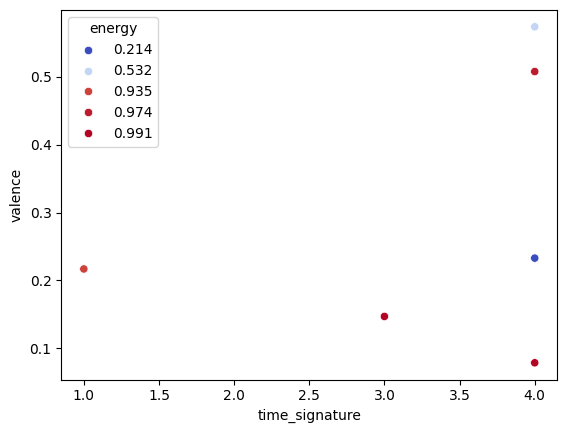

In [41]:
# Usando una paleta de colores que varía con una variable numérica
sns.scatterplot(data=df_BMR_Features, x='time_signature', y='valence', hue='energy', palette='coolwarm')

# Mostrar el gráfico
plt.show()


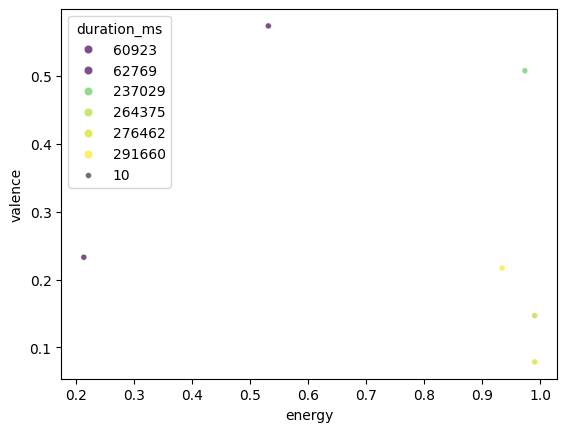

In [42]:
# Ajustando la opacidad y el tamaño de los puntos
sns.scatterplot(data=df_BMR_Features, x='energy', y='valence', hue='duration_ms', palette='viridis', alpha=0.7, size=10)

# Mostrar el gráfico
plt.show()


In [43]:
df_BMR_Features['duration_ms'].describe()

count         6.000000
mean     198869.666667
std      107638.630500
min       60923.000000
25%      106334.000000
50%      250702.000000
75%      273440.250000
max      291660.000000
Name: duration_ms, dtype: float64

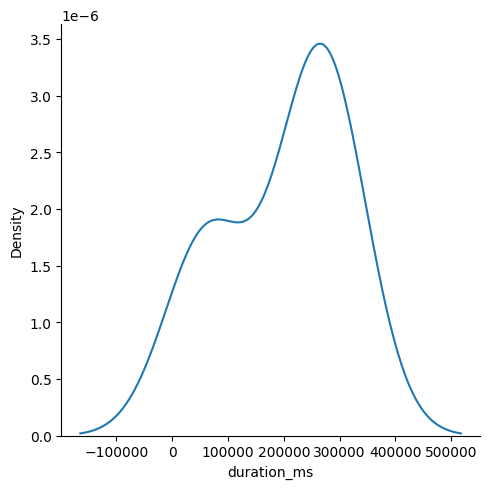

In [44]:
sns.displot(data=df_BMR_Features['duration_ms'],kind='kde')

<Axes: ylabel='duration_ms'>

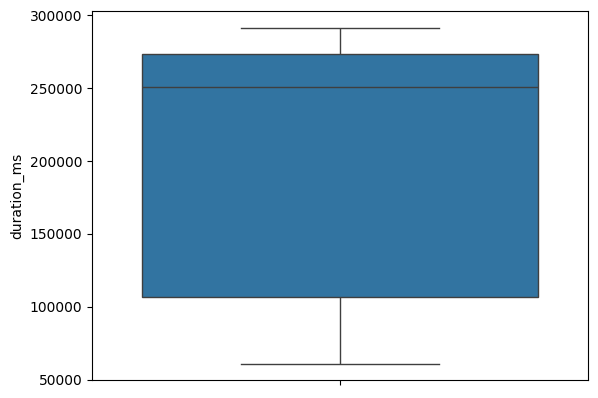

In [45]:
sns.boxplot(data=df_BMR_Features['duration_ms'])

In [46]:
max_duration = df_BMR_Features['duration_ms'].max()
max_duration

291660

In [47]:
min_duration = df_BMR_Features['duration_ms'].min()
max_duration = df_BMR_Features['duration_ms'].max()
mean_duration=df_BMR_Features['duration_ms'].mean()
STD=df_BMR_Features['duration_ms'].std()
bins = [0,18000 ,360000,600000 ]  # Ejemplo de límites en milisegundos
labels = ['Corto', 'Medio', 'Largo']
df_BMR_Features['Duracion'] = pd.cut(df_BMR_Features['duration_ms'], bins=bins, labels=labels)

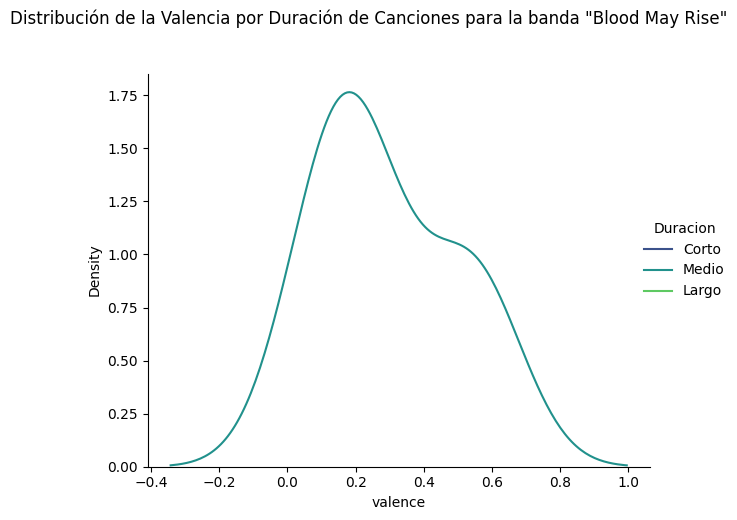

In [48]:
# Crear un displot con hue basado en las categorías de duración
g=sns.displot(data=df_BMR_Features, x='valence', hue='Duracion', kind='kde', palette='viridis')
g.fig.suptitle('Distribución de la Valencia por Duración de Canciones para la banda "Blood May Rise"', y=1.03)
plt.tight_layout()
plt.savefig('BmR.png')
plt.show()


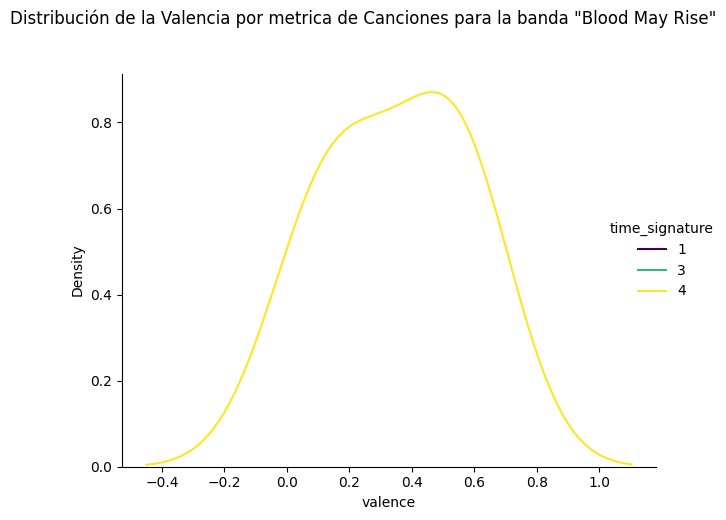

In [49]:
# Crear un displot con hue basado en las categorías de duración
g=sns.displot(data=df_BMR_Features, x='valence', hue='time_signature', kind='kde', palette='viridis')
g.fig.suptitle('Distribución de la Valencia por metrica de Canciones para la banda "Blood May Rise"', y=1.03)
plt.tight_layout()
plt.savefig('Blood May Rise.png')
plt.show()


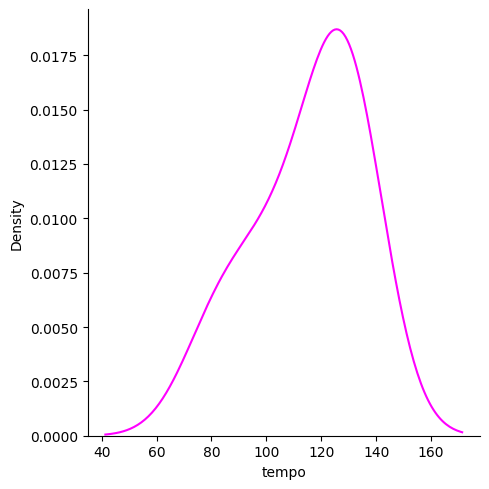

In [50]:
sns.displot(df_BMR_Features['tempo'],kind='kde',color='magenta')

In [51]:
df_BMR_Features['tempo'].describe()

count      6.000000
mean     115.036833
std       19.622371
min       82.511000
25%      105.022000
50%      123.138500
75%      130.011000
max      130.148000
Name: tempo, dtype: float64

In [52]:
min_tempo = df_BMR_Features['tempo'].min()
max_tempo = df_BMR_Features['tempo'].max()
#mean_tempo=df_BMR_Features['tempo'].mean()
#STD_tempo=df_BMR_Features['tempo'].std()
# Definir los límites de los bins basados en la clasificación dada
bins = [0, 66, 120, max_tempo]  # Los límites son 66 y 120 bpm según la clasificación tradicional

# Crear las etiquetas para los bins
labels = ['Lento', 'Moderado', 'Rápido']

# Asignar las categorías de tempo a una nueva columna en el DataFrame
df_BMR_Features['tempo_category'] = pd.cut(df_BMR_Features['tempo'], bins=bins, labels=labels, include_lowest=True)


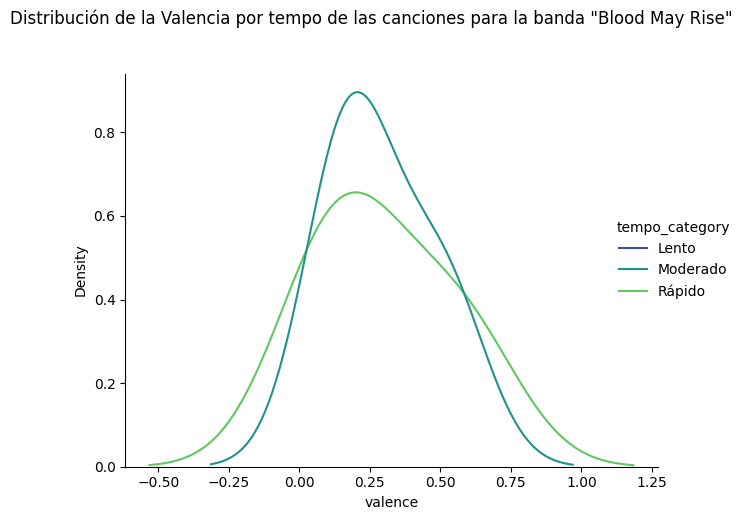

In [53]:
# Crear un displot con hue basado en las categorías de duración
g=sns.displot(data=df_BMR_Features, x='valence', hue='tempo_category', kind='kde', palette='viridis')
g.fig.suptitle('Distribución de la Valencia por tempo de las canciones para la banda "Blood May Rise"', y=1.03)
plt.tight_layout()
plt.savefig('BmR_tempo.png')
plt.show()


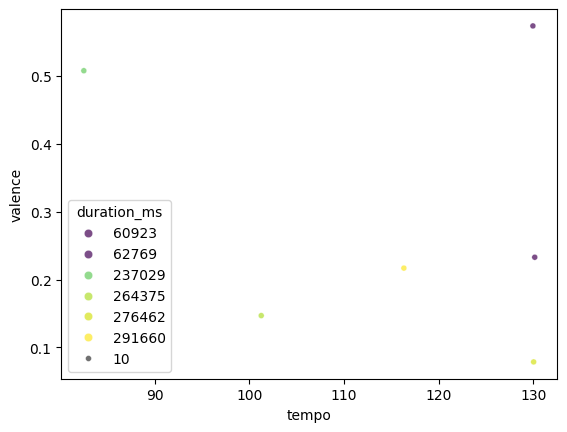

In [54]:
# Ajustando la opacidad y el tamaño de los puntos
sns.scatterplot(data=df_BMR_Features, x='tempo', y='valence', hue='duration_ms', palette='viridis', alpha=0.7, size=10)

# Mostrar el gráfico
plt.show()

In [55]:
df_BMR_Features

,acousticness,danceability,duration_ms,energy,id,instrumentalness,liveness,loudness,speechiness,valence,mode,tempo,time_signature,Duracion,tempo_category
0,0.009690,0.713,62769,0.532,4B7EifbgltSqFAHeHecUUD,0.848000,0.156,-13.107,0.0466,0.5740,0,129.954,4,Medio,Rápido
1,0.000188,0.189,237029,0.974,3bh4GkOcNDYAuEdGCHzBqW,0.002630,0.335,-4.926,0.1050,0.5080,1,82.511,4,Medio,Moderado
2,0.000061,0.534,276462,0.991,3ux9SHfmAPUxcSbFDTnCLQ,0.000542,0.106,-4.072,0.1220,0.0787,1,130.030,4,Medio,Rápido
3,0.024100,0.777,60923,0.214,1qh2wjn5HHe1NiTcrwbIu0,0.706000,0.548,-20.367,0.2720,0.2330,1,130.148,4,Medio,Rápido
4,0.000084,0.285,291660,0.935,4jHQPURzSt1fhNvavRyXAB,0.000545,0.296,-6.036,0.0929,0.2170,1,116.323,1,Medio,Moderado
5,0.000036,0.464,264375,0.991,4SFNkROtU1hNjP6HXj2Dbm,0.093900,0.138,-5.589,0.0604,0.1470,1,101.255,3,Medio,Moderado


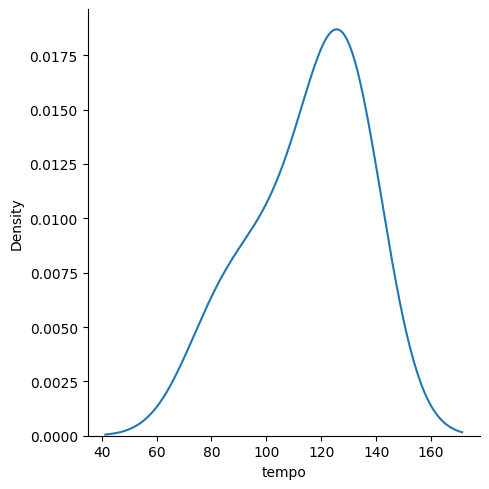

In [56]:
sns.displot(data=df_BMR_Features, x='tempo',kind='kde')

In [57]:
top_5 = df_BMR_Features.nlargest(5, 'valence')
top_5


,acousticness,danceability,duration_ms,energy,id,instrumentalness,liveness,loudness,speechiness,valence,mode,tempo,time_signature,Duracion,tempo_category
0,0.009690,0.713,62769,0.532,4B7EifbgltSqFAHeHecUUD,0.848000,0.156,-13.107,0.0466,0.574,0,129.954,4,Medio,Rápido
1,0.000188,0.189,237029,0.974,3bh4GkOcNDYAuEdGCHzBqW,0.002630,0.335,-4.926,0.1050,0.508,1,82.511,4,Medio,Moderado
3,0.024100,0.777,60923,0.214,1qh2wjn5HHe1NiTcrwbIu0,0.706000,0.548,-20.367,0.2720,0.233,1,130.148,4,Medio,Rápido
4,0.000084,0.285,291660,0.935,4jHQPURzSt1fhNvavRyXAB,0.000545,0.296,-6.036,0.0929,0.217,1,116.323,1,Medio,Moderado
5,0.000036,0.464,264375,0.991,4SFNkROtU1hNjP6HXj2Dbm,0.093900,0.138,-5.589,0.0604,0.147,1,101.255,3,Medio,Moderado


In [58]:
merged_Features = pd.merge(df_BMR_Features, tracks_df, left_on='id', right_on='id', suffixes=('_features', '_tracks'))

In [59]:
merged_Features

,acousticness,danceability,duration_ms_features,energy,id,instrumentalness,liveness,loudness,speechiness,valence,...,duration_ms_tracks,explicit,external_urls,href,is_local,name,preview_url,track_number,type,uri
0,0.009690,0.713,62769,0.532,4B7EifbgltSqFAHeHecUUD,0.848000,0.156,-13.107,0.0466,0.5740,...,62769,False,{'spotify': 'https://open.spotify.com/track/4B...,https://api.spotify.com/v1/tracks/4B7EifbgltSq...,False,RENGOKU 煉獄,https://p.scdn.co/mp3-preview/68219a0b092c2e0d...,1,track,spotify:track:4B7EifbgltSqFAHeHecUUD
1,0.000188,0.189,237029,0.974,3bh4GkOcNDYAuEdGCHzBqW,0.002630,0.335,-4.926,0.1050,0.5080,...,237028,False,{'spotify': 'https://open.spotify.com/track/3b...,https://api.spotify.com/v1/tracks/3bh4GkOcNDYA...,False,Neon Genesis,https://p.scdn.co/mp3-preview/f554dae13085d9b3...,1,track,spotify:track:3bh4GkOcNDYAuEdGCHzBqW
2,0.000061,0.534,276462,0.991,3ux9SHfmAPUxcSbFDTnCLQ,0.000542,0.106,-4.072,0.1220,0.0787,...,276461,False,{'spotify': 'https://open.spotify.com/track/3u...,https://api.spotify.com/v1/tracks/3ux9SHfmAPUx...,False,King Of Curses,https://p.scdn.co/mp3-preview/931c307090f0bef6...,1,track,spotify:track:3ux9SHfmAPUxcSbFDTnCLQ
3,0.024100,0.777,60923,0.214,1qh2wjn5HHe1NiTcrwbIu0,0.706000,0.548,-20.367,0.2720,0.2330,...,60923,True,{'spotify': 'https://open.spotify.com/track/1q...,https://api.spotify.com/v1/tracks/1qh2wjn5HHe1...,False,Gambare,https://p.scdn.co/mp3-preview/c9d9e9dad195e186...,1,track,spotify:track:1qh2wjn5HHe1NiTcrwbIu0
4,0.000084,0.285,291660,0.935,4jHQPURzSt1fhNvavRyXAB,0.000545,0.296,-6.036,0.0929,0.2170,...,291660,True,{'spotify': 'https://open.spotify.com/track/4j...,https://api.spotify.com/v1/tracks/4jHQPURzSt1f...,False,Eren,https://p.scdn.co/mp3-preview/2aa4e1e54ca6d54d...,1,track,spotify:track:4jHQPURzSt1fhNvavRyXAB
5,0.000036,0.464,264375,0.991,4SFNkROtU1hNjP6HXj2Dbm,0.093900,0.138,-5.589,0.0604,0.1470,...,264375,False,{'spotify': 'https://open.spotify.com/track/4S...,https://api.spotify.com/v1/tracks/4SFNkROtU1hN...,False,Achilles,https://p.scdn.co/mp3-preview/2ddb437706e189ee...,1,track,spotify:track:4SFNkROtU1hNjP6HXj2Dbm


In [60]:
merged_Features.columns

Index(['acousticness', 'danceability', 'duration_ms_features', 'energy', 'id',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'mode', 'tempo', 'time_signature', 'Duracion', 'tempo_category',
       'artists', 'available_markets', 'disc_number', 'duration_ms_tracks',
       'explicit', 'external_urls', 'href', 'is_local', 'name', 'preview_url',
       'track_number', 'type', 'uri'],
      dtype='object')

In [61]:
merged_Features_Filter=merged_Features[['energy','duration_ms_tracks','tempo','valence','name']].nlargest(5, 'valence')

In [62]:
merged_Features_Filter

,energy,duration_ms_tracks,tempo,valence,name
0,0.532,62769,129.954,0.574,RENGOKU 煉獄
1,0.974,237028,82.511,0.508,Neon Genesis
3,0.214,60923,130.148,0.233,Gambare
4,0.935,291660,116.323,0.217,Eren
5,0.991,264375,101.255,0.147,Achilles


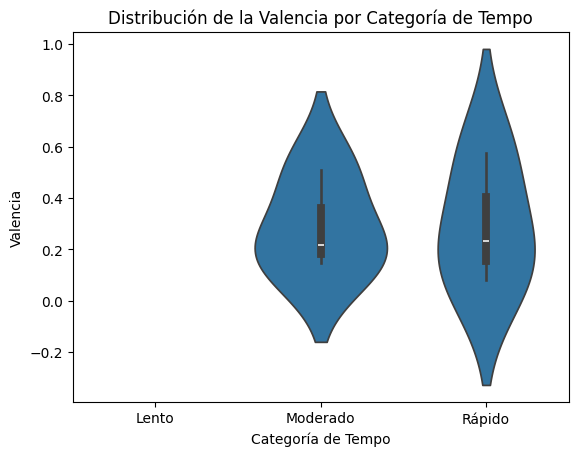

In [63]:
sns.violinplot(x='tempo_category', y='valence', data=df_BMR_Features, order=['Lento', 'Moderado', 'Rápido'])
plt.title('Distribución de la Valencia por Categoría de Tempo')
plt.xlabel('Categoría de Tempo')
plt.ylabel('Valencia')
plt.show()